In [1]:
from filterpy.kalman import unscented_transform as ut
from filterpy.kalman import MerweScaledSigmaPoints, JulierSigmaPoints, SimplexSigmaPoints
import scipy.stats as stats
import numpy as np
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt

from scipy.stats.mstats import mquantiles
import matplotlib.patches as patches

In [2]:
def plot_ellipse(ax, x, y):

    # Estimate the quantiles of the data distribution
    quantiles = mquantiles(np.stack((x, y), axis=1), [0.025, 0.975], axis=0)

    # Calculate the width and height of the ellipse based on the quantiles
    width = quantiles[1, 0] - quantiles[0, 0]
    height = quantiles[1, 1] - quantiles[0, 1]

    # Calculate the center of the ellipse
    center = np.mean(np.stack((quantiles[0], quantiles[1]), axis=0), axis=0)

    # Create the ellipse
    ellipse = patches.Ellipse(xy=center, width=width, height=height, angle=0, fill=False, edgecolor='k', linestyle='--')

    # Plot the ellipse
    ax.add_patch(ellipse)

def plot_ukf(mean, cov, ax):
    ax.scatter(mean[0], mean[1], c='y', s=100, label='UT Mean', marker='*')

    # visualize UFK covariance
    eigvals, eigvecs = np.linalg.eig(cov)
    eigvals = 2 * np.sqrt(eigvals)

    theta = np.linspace(0, 2*np.pi, 1000);
    ellipsis = (eigvals[None,:] * eigvecs) @ [np.sin(theta), np.cos(theta)]
    ax.plot(mean[0] + ellipsis[0,:], mean[1] + ellipsis[1,:], c='y', label='UT Covariance')

In [3]:
def f_nonlinear_xy(x, y):
    return np.array([x + y, .1*x**2 + y*y])

In [4]:
def get_weights_merwe(n, alpha, beta, kappa):

    lambda_ = alpha**2 * (n + kappa) - n

    Wc = np.full(2*n + 1, 1 / (2*(n + lambda_)))
    Wm = Wc.copy()

    Wc[0] = lambda_ / (n + lambda_) + (1 - alpha**2 + beta)
    Wm[0] = lambda_ / (n + lambda_)
    
    return Wm, Wc

def get_sigmas_merwe(mean, cov, alpha, kappa):

    n = len(mean)

    sigmas = np.empty((2*n + 1, n))

    lambda_ = alpha**2 * (n + kappa) - n
    U = np.linalg.cholesky((n + lambda_) * cov)

    sigmas[0] = mean
    for i in range(n):
        sigmas[i + 1] = mean + U[i]
        sigmas[n + i + 1] = mean - U[i]

    return sigmas

def get_weights_julier(n, kappa):

    Wm = np.full(2*n + 1, 1 / (2*(n + kappa)))
    Wm[0] = kappa / (n + kappa)

    Wc = Wm.copy()
    
    return Wm, Wc

def get_sigmas_julier(mean, cov, kappa):
    
        n = len(mean)
    
        sigmas = np.empty((2*n + 1, n))
    
        U = np.linalg.cholesky((n + kappa) * cov)
    
        sigmas[0] = mean
        for i in range(n):
            sigmas[i + 1] = mean + U[i]
            sigmas[n + i + 1] = mean - U[i]
    
        return sigmas

def get_weights_simplex(n):
    
        Wm = np.full(n + 1, 1 / (n + 1))
        Wc = Wm.copy()
        
        return Wm, Wc

def get_sigmas_simplex(mean, cov):
        
        n = len(mean)
    
        lambda_ = n / (n + 1)

        U = np.linalg.cholesky(cov)

        Istar = np.array([[-1/np.sqrt(2*lambda_), 1/np.sqrt(2*lambda_)]])

        for d in range(2, n+1):
            row = np.ones((1, Istar.shape[1] + 1)) * 1. / np.sqrt(lambda_*d*(d + 1))
            row[0, -1] = -d / np.sqrt(lambda_ * d * (d + 1))
            Istar = np.r_[np.c_[Istar, np.zeros((Istar.shape[0]))], row]

        I = np.sqrt(n)*Istar
        scaled_unitary = U.dot(I)

        mean = np.array(mean).reshape(2, 1) 
        sigmas = np.subtract(mean, -scaled_unitary)
        return sigmas.T

def unscented_transform(mean, cov, alpha=.5, beta=2, kappa=0, method='merwe'):

    def f_nonlinear_xy(x, y):
        return np.array([x + y, .1*x**2 + y*y])

    n = len(mean)

    if method == 'merwe':
        Wm, Wc = get_weights_merwe(n, alpha, beta, kappa)
        sigmas = get_sigmas_merwe(mean, cov, alpha, kappa)
    
    elif method == 'julier':
        Wm, Wc = get_weights_julier(n, kappa)
        sigmas = get_sigmas_julier(mean, cov, kappa)

    elif method == 'simplex':
        Wm, Wc = get_weights_simplex(n)
        sigmas = get_sigmas_simplex(mean, cov)

    else:
        raise ValueError('Unknown method')
    
    n_sigmas = len(sigmas)
    
    mean = np.sum(Wm * sigmas.T, axis=1)


    sigmas_f = np.empty((n_sigmas, n))

    for i in range(n_sigmas):
        sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i, 1])
    
    cov = np.zeros((n, n))
    for i in range(n_sigmas):
        y = sigmas_f[i] - mean
        cov += Wc[i] * np.outer(y, y)

    return mean, cov, sigmas, sigmas_f

In [5]:
def plot_sigma_point_illustration(ut_dict, xs, ys, xs_nl, ys_nl):

    methods = ['merwe', 'julier', 'simplex']

    fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

    alpha = .4

    for i, method in enumerate(methods):
        mean = ut_dict[method]['mean']
        cov = ut_dict[method]['cov']
        sigmas = ut_dict[method]['sigmas']
        sigmas_f = ut_dict[method]['sigmas_f']

        ax[i].scatter(xs_nl, ys_nl, c='g', s=30, alpha=alpha)
        ax[i].scatter(xs, ys, c='b', s=30, alpha=alpha)

        ax[i].scatter(sigmas[:,0], sigmas[:,1], c='r', s=50, label='Sigma Points')
        ax[i].scatter(sigmas_f[:,0], sigmas_f[:,1], c='k', s=50, label='Transformed Sigma Points')

        plot_ukf(mean, cov, ax[i])
        ax[i].set_title(method)

    ax[0].legend(loc=2)

    plt.tight_layout()
    plt.show()

In [6]:
# initial mean and covariance
mean = (0., 0.)
p = np.array([[32., 15], [15., 40.]])

n = len(mean)

# generate random points
np.random.seed(100)
xs, ys = multivariate_normal(mean=mean, cov=p, size=3000).T

# pass through nonlinear function
xs_nl, ys_nl = f_nonlinear_xy(xs, ys)

alpha = .5
beta = 2
kappa = 0

In [7]:
points = MerweScaledSigmaPoints(n=n, alpha=alpha, beta=beta, kappa=kappa)
sigmas_merwe = points.sigma_points(mean, p)

points_julier = JulierSigmaPoints(n=n, kappa=1)
sigmas_julier = points_julier.sigma_points(mean, p)

points_simplex = SimplexSigmaPoints(n=2, alpha=1)
sigmas_simplex = points_simplex.sigma_points(np.array(mean), p)

sigmas_f = np.empty((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas_merwe[i, 0], sigmas_merwe[i ,1])

sigmas_f_julier = np.empty((5, 2))
for i in range(5):
    sigmas_f_julier[i] = f_nonlinear_xy(sigmas_julier[i, 0], sigmas_julier[i ,1])

sigmas_f_simplex = np.empty((3, 2))
for i in range(3):
    sigmas_f_simplex[i] = f_nonlinear_xy(sigmas_simplex[i, 0], sigmas_simplex[i ,1])


### use unscented transform to get new mean and covariance
ukf_mean, ukf_cov = ut(sigmas_f, points.Wm, points.Wc)
ukf_mean_julier, ukf_cov_julier = ut(sigmas_f_julier, points_julier.Wm, points_julier.Wc)
ukf_mean_simplex, ukf_cov_simplex = ut(sigmas_f_simplex, points_simplex.Wm, points_simplex.Wc)

ut_dict_kalmanpy = { 'merwe': {'mean': ukf_mean, 'cov': ukf_cov, 'sigmas': sigmas_merwe, 'sigmas_f': sigmas_f},
            'julier': {'mean': ukf_mean_julier, 'cov': ukf_cov_julier, 'sigmas': sigmas_julier, 'sigmas_f': sigmas_f_julier},
            'simplex': {'mean': ukf_mean_simplex, 'cov': ukf_cov_simplex, 'sigmas': sigmas_simplex, 'sigmas_f': sigmas_f_simplex}}


In [9]:
mean_ut_merwe, cov_ut_merwe, sigmas_merwe, sigmas_f_merwe = unscented_transform(mean, p, method='merwe')
mean_ut_julier, cov_ut_julier, sigmas_julier, sigmas_f_julier = unscented_transform(mean, p, method='julier')
mean_ut_simplex, cov_ut_simplex, sigmas_simplex, sigmas_f_simplex = unscented_transform(mean, p, method='simplex')

# collect in dictionary
ut_dict = { 'merwe': {'mean': mean_ut_merwe, 'cov': cov_ut_merwe, 'sigmas': sigmas_merwe, 'sigmas_f': sigmas_f_merwe},
            'julier': {'mean': mean_ut_julier, 'cov': cov_ut_julier, 'sigmas': sigmas_julier, 'sigmas_f': sigmas_f_julier},
            'simplex': {'mean': mean_ut_simplex, 'cov': cov_ut_simplex, 'sigmas': sigmas_simplex, 'sigmas_f': sigmas_f_simplex}}

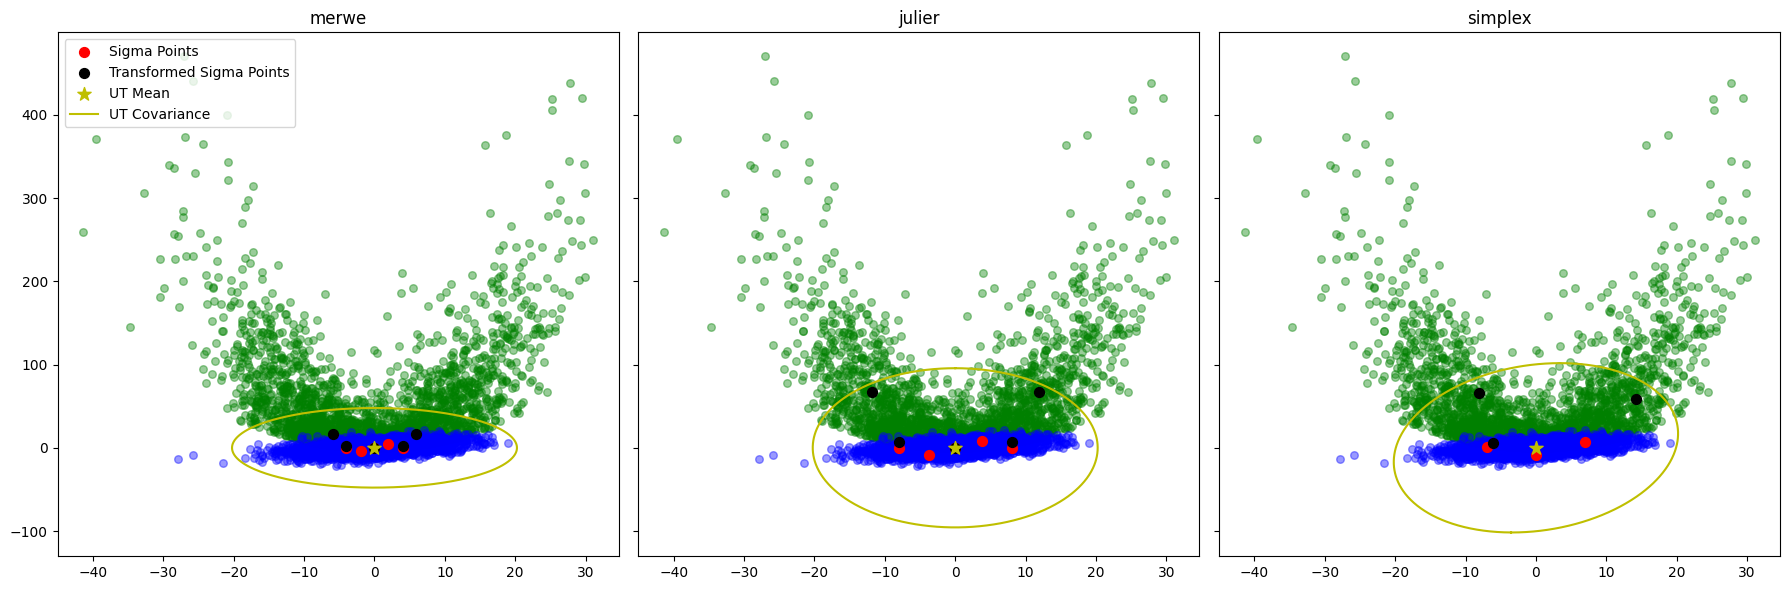

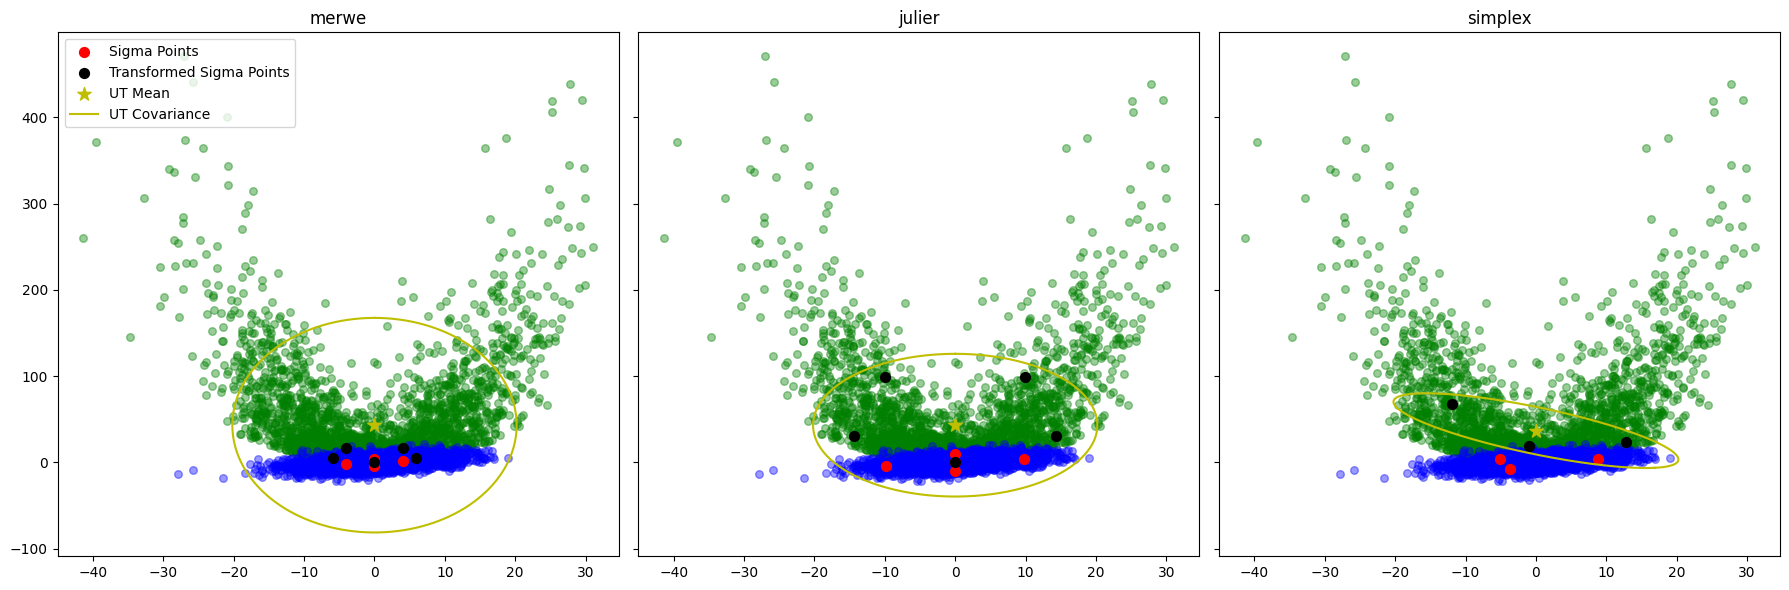

In [12]:
plot_sigma_point_illustration(ut_dict, xs, ys, xs_nl, ys_nl)
plot_sigma_point_illustration(ut_dict_kalmanpy, xs, ys, xs_nl, ys_nl)